## 金融风控项目
在此项目中，你需要完成金融风控模型的搭建。 基于一个用户的基本信息、历史信息来预测逾期与否。采样的具体数据是拍拍贷数据。https://www.kesci.com/home/competition/56cd5f02b89b5bd026cb39c9/content/1
在此数据中提供了三种不同类型的数据:
1. Master: 用户的主要信息
2. Loginfo: 登录信息
3. Userupdateinfo: 修改信息

在本次项目中，我们只使用```Master```的信息来预测一个用户是否会逾期。 数据里有一个字段叫作```Target```是样本的标签（label)。 在```Master```表格里，包含200多个特征，但不少特征具有缺失值。 做项目的时候需要仔细处理一下。 

对于特征处理方面的技术，请参考本章视频课程里的内容。

本项目区别于之前的项目，希望大家能够开放性地思考，不要太局限于给定的条条框框，把目前为止学到的知识都用起来。所以在项目的设计上区别于之前的，没有设置太多的框架性的，大家可以按照自己的思路灵活做项目。 由于项目本身来自于数据竞赛，所以可以试着跟竞赛里的TOP选手的结果做一下对比，看看跟他们的差距或者优势在哪儿。

```数据```
- ```Training/PPD_Training_Master_GBK_3_1_Training_Set.csv```:  训练数据
- ```Test/PPD_Master_GBK_2_Test_Set.csv```: 测试数据


强调：一定要把注释写清楚。 每个函数，每一个模块具体做什么写清楚。

> 注意： 除了下面导入的库，还有sklearn、XGBoost等经典的库之外，建议不要使用其他的函数库。 如果你不得不使用一些其他特殊的库，请把环境注明在requirements.txt里面，不然我们判作业的时候就没有办法去评判了。 

In [87]:
import math
import os 
import warnings

import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.tree import DecisionTreeClassifier
# from xgboost import XGBClassifier
# from imblearn.over_sampling import SMOTE

%matplotlib inline
sns.set_palette('muted')
sns.set_style('darkgrid')
pd.set_option('display.float_format',lambda x:'%.3f' % x)
pd.set_option("max_columns", 300)
warnings.filterwarnings('ignore')

print('导入及设置成功')

导入及设置成功


In [88]:
# 读取Master数据
data = pd.read_csv('data/Training/PPD_Training_Master_GBK_3_1_Training_Set.csv',encoding='gb18030')
print (data.shape)

(30000, 228)


In [89]:
# 展示记录
pd.set_option("max_columns", 500)
data.head()

,Idx,UserInfo_1,UserInfo_2,UserInfo_3,UserInfo_4,WeblogInfo_1,WeblogInfo_2,WeblogInfo_3,WeblogInfo_4,WeblogInfo_5,WeblogInfo_6,WeblogInfo_7,WeblogInfo_8,WeblogInfo_9,WeblogInfo_10,WeblogInfo_11,WeblogInfo_12,WeblogInfo_13,WeblogInfo_14,WeblogInfo_15,WeblogInfo_16,WeblogInfo_17,WeblogInfo_18,UserInfo_5,UserInfo_6,UserInfo_7,UserInfo_8,UserInfo_9,UserInfo_10,UserInfo_11,UserInfo_12,UserInfo_13,UserInfo_14,UserInfo_15,UserInfo_16,UserInfo_17,UserInfo_18,UserInfo_19,UserInfo_20,UserInfo_21,UserInfo_22,UserInfo_23,UserInfo_24,Education_Info1,Education_Info2,Education_Info3,Education_Info4,Education_Info5,Education_Info6,Education_Info7,Education_Info8,WeblogInfo_19,WeblogInfo_20,WeblogInfo_21,WeblogInfo_23,WeblogInfo_24,WeblogInfo_25,WeblogInfo_26,WeblogInfo_27,WeblogInfo_28,WeblogInfo_29,WeblogInfo_30,WeblogInfo_31,WeblogInfo_32,WeblogInfo_33,WeblogInfo_34,WeblogInfo_35,WeblogInfo_36,WeblogInfo_37,WeblogInfo_38,WeblogInfo_39,WeblogInfo_40,WeblogInfo_41,WeblogInfo_42,WeblogInfo_43,WeblogInfo_44,WeblogInfo_45,WeblogInfo_46,WeblogInfo_47,WeblogInfo_48,WeblogInfo_49,WeblogInfo_50,WeblogInfo_51,WeblogInfo_52,WeblogInfo_53,WeblogInfo_54,WeblogInfo_55,WeblogInfo_56,WeblogInfo_57,WeblogInfo_58,ThirdParty_Info_Period1_1,ThirdParty_Info_Period1_2,ThirdParty_Info_Period1_3,ThirdParty_Info_Period1_4,ThirdParty_Info_Period1_5,ThirdParty_Info_Period1_6,ThirdParty_Info_Period1_7,ThirdParty_Info_Period1_8,ThirdParty_Info_Period1_9,ThirdParty_Info_Period1_10,ThirdParty_Info_Period1_11,ThirdParty_Info_Period1_12,ThirdParty_Info_Period1_13,ThirdParty_Info_Period1_14,ThirdParty_Info_Period1_15,ThirdParty_Info_Period1_16,ThirdParty_Info_Period1_17,ThirdParty_Info_Period2_1,ThirdParty_Info_Period2_2,ThirdParty_Info_Period2_3,ThirdParty_Info_Period2_4,ThirdParty_Info_Period2_5,ThirdParty_Info_Period2_6,ThirdParty_Info_Period2_7,ThirdParty_Info_Period2_8,ThirdParty_Info_Period2_9,ThirdParty_Info_Period2_10,ThirdParty_Info_Period2_11,ThirdParty_Info_Period2_12,ThirdParty_Info_Period2_13,ThirdParty_Info_Period2_14,ThirdParty_Info_Period2_15,ThirdParty_Info_Period2_16,ThirdParty_Info_Period2_17,ThirdParty_Info_Period3_1,ThirdParty_Info_Period3_2,ThirdParty_Info_Period3_3,ThirdParty_Info_Period3_4,ThirdParty_Info_Period3_5,ThirdParty_Info_Period3_6,ThirdParty_Info_Period3_7,ThirdParty_Info_Period3_8,ThirdParty_Info_Period3_9,ThirdParty_Info_Period3_10,ThirdParty_Info_Period3_11,ThirdParty_Info_Period3_12,ThirdParty_Info_Period3_13,ThirdParty_Info_Period3_14,ThirdParty_Info_Period3_15,ThirdParty_Info_Period3_16,ThirdParty_Info_Period3_17,ThirdParty_Info_Period4_1,ThirdParty_Info_Period4_2,ThirdParty_Info_Period4_3,ThirdParty_Info_Period4_4,ThirdParty_Info_Period4_5,ThirdParty_Info_Period4_6,ThirdParty_Info_Period4_7,ThirdParty_Info_Period4_8,ThirdParty_Info_Period4_9,ThirdParty_Info_Period4_10,ThirdParty_Info_Period4_11,ThirdParty_Info_Period4_12,ThirdParty_Info_Period4_13,ThirdParty_Info_Period4_14,ThirdParty_Info_Period4_15,ThirdParty_Info_Period4_16,ThirdParty_Info_Period4_17,ThirdParty_Info_Period5_1,ThirdParty_Info_Period5_2,ThirdParty_Info_Period5_3,ThirdParty_Info_Period5_4,ThirdParty_Info_Period5_5,ThirdParty_Info_Period5_6,ThirdParty_Info_Period5_7,ThirdParty_Info_Period5_8,ThirdParty_Info_Period5_9,ThirdParty_Info_Period5_10,ThirdParty_Info_Period5_11,ThirdParty_Info_Period5_12,ThirdParty_Info_Period5_13,ThirdParty_Info_Period5_14,ThirdParty_Info_Period5_15,ThirdParty_Info_Period5_16,ThirdParty_Info_Period5_17,ThirdParty_Info_Period6_1,ThirdParty_Info_Period6_2,ThirdParty_Info_Period6_3,ThirdParty_Info_Period6_4,ThirdParty_Info_Period6_5,ThirdParty_Info_Period6_6,ThirdParty_Info_Period6_7,ThirdParty_Info_Period6_8,ThirdParty_Info_Period6_9,ThirdParty_Info_Period6_10,ThirdParty_Info_Period6_11,ThirdParty_Info_Period6_12,ThirdParty_Info_Period6_13,ThirdParty_Info_Period6_14,ThirdParty_Info_Period6_15,ThirdParty_Info_Period6_16,ThirdParty_Info_Period6_17,ThirdParty_Info_Period7_1,ThirdParty_Info_Period7_2,ThirdParty_Info_Period7_3,ThirdParty_Info_Perio

In [90]:
# 正负样本的比例， 可以看出样本比例不平衡的
data.target.value_counts()

0    27802
1     2198
Name: target, dtype: int64

好了，剩下的部分需要由大家完成。 我大致给一下思路，然后大家可以按照这个思路去一步步完成。 

> #### 1. 数据的预处。 需要考虑以下几个方面：
- ```缺失值```。数据里有大量的缺失值，需要做一些处理。 
- ```字符串的清洗```。比如“北京市”和“北京”合并成“北京”， 统一转换成小写等
- ```二值化```。具体方法请参考课程里的介绍
- ```衍生特征```：比如户籍地和当前城市是否是同一个？ 
- ```特征的独热编码```：对于类别型特征使用独热编码形式
- ```连续性特征的处理```：根据情况来处理
- ```其他```: 根据情况，自行决定要不要做

In [91]:
data_nan = data.isnull().sum()
# print(data_nan)
# print(data_nan.index)
pd.set_option("max_columns", 500)
pdFrame = pd.DataFrame(data= data_nan.values, index= data_nan.index, columns= ['特性缺失值数量'])
pdFrameNan = pdFrame[pdFrame["特性缺失值数量"]>0]
# pdFrameNan.head()
pdFrameNan["特性缺失值数量占比"] = pdFrameNan['特性缺失值数量']/len(data_nan)
pdFrameNan.head()

,特性缺失值数量,特性缺失值数量占比
UserInfo_1,6,0.026
UserInfo_2,302,1.325
UserInfo_3,7,0.031
UserInfo_4,268,1.175
WeblogInfo_1,29030,127.325


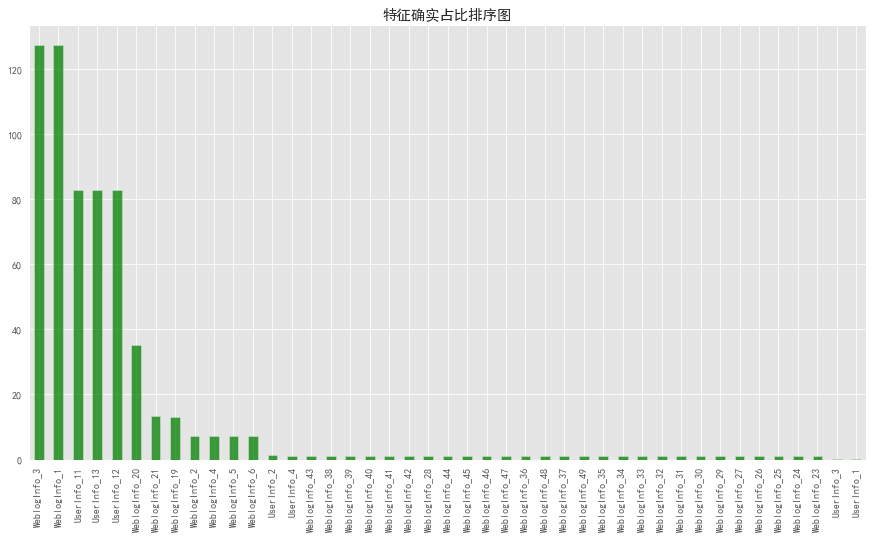

In [92]:
def bar_figure(plot_data, title, figsize):
    matplotlib.style.use('ggplot')
    # 指定默认字体 SimHei为黑体
    matplotlib.rcParams['font.sans-serif'] = ['SimHei']
    # 正常显示负号
    matplotlib.rcParams['axes.unicode_minus'] = False 
    plt.figure()
    plot_data.plot(kind='bar', figsize=figsize, color='g', grid=True, alpha=0.75)
    plt.title(label=title)
    return plt.show()
pdFrameNan.sort_values(by = '特性缺失值数量占比',axis=0,ascending=False,inplace=True)
bar_figure(pdFrameNan['特性缺失值数量占比'],"特征确实占比排序图",figsize=(15,8))
# b =pdFrameNan['特性缺失值数量占比']
# print(b)

In [93]:
# pdFrameNan.head()
data.drop(columns=['WeblogInfo_3','WeblogInfo_1','UserInfo_11','UserInfo_13','UserInfo_12'],inplace=True)
# b = data['WeblogInfo_3']


In [94]:
# pd.set_option("max_rows", 500)
print(pdFrameNan)
data.head(data)


               特性缺失值数量  特性缺失值数量占比
WeblogInfo_3     29030    127.325
WeblogInfo_1     29030    127.325
UserInfo_11      18909     82.934
UserInfo_13      18909     82.934
UserInfo_12      18909     82.934
WeblogInfo_20     8050     35.307
WeblogInfo_21     3074     13.482
WeblogInfo_19     2963     12.996
WeblogInfo_2      1658      7.272
WeblogInfo_4      1651      7.241
WeblogInfo_5      1651      7.241
WeblogInfo_6      1651      7.241
UserInfo_2         302      1.325
UserInfo_4         268      1.175
WeblogInfo_43      253      1.110
WeblogInfo_38      253      1.110
WeblogInfo_39      253      1.110
WeblogInfo_40      253      1.110
WeblogInfo_41      253      1.110
WeblogInfo_42      253      1.110
WeblogInfo_28      253      1.110
WeblogInfo_44      253      1.110
WeblogInfo_45      253      1.110
WeblogInfo_46      253      1.110
WeblogInfo_47      253      1.110
WeblogInfo_36      253      1.110
WeblogInfo_48      253      1.110
WeblogInfo_37      253      1.110
WeblogInfo_49 

TypeError: cannot do slice indexing on <class 'pandas.core.indexes.range.RangeIndex'> with these indexers [         Idx  UserInfo_1 UserInfo_2  UserInfo_3 UserInfo_4  WeblogInfo_2  \
0      10001       1.000         深圳       4.000         深圳         1.000   
1      10002       1.000         温州       4.000         温州         0.000   
2      10003       1.000         宜昌       3.000         宜昌         0.000   
3      10006       4.000         南平       1.000         南平           nan   
4      10007       5.000         辽阳       1.000         辽阳         0.000   
...      ...         ...        ...         ...        ...           ...   
29995   9991       3.000         南阳       4.000         南阳         1.000   
29996   9992       3.000         宁德       4.000         泉州         0.000   
29997   9995       1.000         天津       2.000         天津         0.000   
29998   9997       3.000         运城       3.000         运城         0.000   
29999   9998       4.000         金华       5.000         无锡         0.000   

       WeblogInfo_4  WeblogInfo_5  WeblogInfo_6  WeblogInfo_7  WeblogInfo_8  \
0             1.000         1.000         1.000            14             0   
1             1.000         1.000         1.000            14             0   
2             2.000         2.000         2.000             9             3   
3               nan           nan           nan             2             0   
4             1.000         1.000         1.000             3             0   
...             ...           ...           ...           ...           ...   
29995         3.000         2.000         3.000            10             0   
29996         6.000         1.000         6.000            16             0   
29997         2.000         2.000         2.000             4             0   
29998         1.000         1.000         1.000            16             0   
29999         1.000         1.000         1.000             3             0   

       WeblogInfo_9  WeblogInfo_10  WeblogInfo_11  WeblogInfo_12  \
0                 0              0              0              0   
1                 0              0              0              0   
2                 0              0              0              0   
3                 0              0              0              0   
4                 0              0              0              0   
...             ...            ...            ...            ...   
29995             0              0              0              0   
29996             0              0              0              0   
29997             0              0              0              0   
29998             0              0              0              0   
29999             0              0              0              0   

       WeblogInfo_13  WeblogInfo_14  WeblogInfo_15  WeblogInfo_16  \
0                  0              6              6              0   
1                  0              0              0              7   
2                  0              0              0              3   
3                  0              0              0              0   
4                  0              0              0              0   
...              ...            ...            ...            ...   
29995              0              0              2              0   
29996              0              7              0              2   
29997              0              0              0              1   
29998              0              6              0              8   
29999              0              0              0              0   

       WeblogInfo_17  WeblogInfo_18  UserInfo_5  UserInfo_6 UserInfo_7  \
0                  6              2           2           2         广东   
1                  7              0           2           2         浙江   
2                  4              2           2           2         湖北   
3                  2              0           2           2         福建   
4                  3              0           2           2         辽宁   
...              ...            ...         ...         ...        ...   
29995              8              0           1           1         河南   
29996             12              2           2           2         福建   
29997              2              1           2           2         不详   
29998              6              2           2           2         不详   
29999              3              0           1           1         浙江   

      UserInfo_8 UserInfo_9  UserInfo_10  UserInfo_14  UserInfo_15  \
0             深圳      中国移动             0            2            2   
1             温州      中国移动             1            3            3   
2             宜昌      中国电信             0            4            4   
3             南平      中国移动             0            2            2   
4             辽阳      中国移动             0            3            3   
...          ...        ...          ...          ...          ...   
29995         南阳      中国联通             0            3            3   
29996         宁德      中国移动             0            3            3   
29997         不详         不详            1            2            2   
29998         不详         不详            0            5            5   
29999         金华      中国电信             0            2            5   

       UserInfo_16  UserInfo_17  UserInfo_18 UserInfo_19 UserInfo_20  \
0                1            1           29         四川省         南充市   
1                2            2           28         福建省          不详   
2                2            1           32         湖北省         宜昌市   
3                1            1           33         江西省          不详   
4                1            1           43         辽宁省         锦州市   
...            ...          ...          ...         ...         ...   
29995            2            1           26         河南省         南阳市   
29996            1            2           28         福建省          不详   
29997            6            2           49         天津市          不详   
29998            2            1           27         山西省          不详   
29999            1            1           25         福建省         南平市   

       UserInfo_21 UserInfo_22 UserInfo_23 UserInfo_24  Education_Info1  \
0                0           D           D           D                0   
1                0           D           D           D                0   
2                0           D           D           D                0   
3                0           D           D           D                0   
4                0           D           D           D                0   
...            ...         ...         ...         ...              ...   
29995            1          不详          不详   河南省南阳市宛城区                0   
29996            0           D           D           D                0   
29997            0           D           D           D                0   
29998            0           D           D           D                0   
29999            0           D           D           D                0   

      Education_Info2 Education_Info3 Education_Info4  Education_Info5  \
0                   E               E               E                0   
1                   E               E               E                0   
2                   E               E               E                0   
3                   E               E               E                0   
4                   E               E               E                0   
...               ...             ...             ...              ...   
29995               E               E               E                0   
29996               E               E               E                0   
29997               E               E               E                0   
29998               E               E               E                0   
29999               E               E               E                0   

      Education_Info6 Education_Info7 Education_Info8 WeblogInfo_19  \
0                   E               E               E             I   
1                   E               E               E             I   
2                   E               E               E             I   
3                   E               E               E             I   
4                   E               E               E             I   
...               ...             ...             ...           ...   
29995               E               E               E             D   
29996               E               E               E             I   
29997               E               E               E             I   
29998               E               E               E             I   
29999               E               E               E             F   

      WeblogInfo_20 WeblogInfo_21  WeblogInfo_23  WeblogInfo_24  \
0                I5             D          0.000          0.000   
1                I5             D          0.000          0.000   
2                I5             D          0.000          0.000   
3                I5             D          0.000          0.000   
4               NaN             D          0.000          0.000   
...             ...           ...            ...            ...   
29995             U             A          0.000          0.000   
29996            I4             D          0.000          0.000   
29997            I5             D          0.000          0.000   
29998            I5             D          0.000          0.000   
29999           NaN             C          0.000          0.000   

       WeblogInfo_25  WeblogInfo_26  WeblogInfo_27  WeblogInfo_28  \
0              0.000          0.000          0.000          0.000   
1              0.000          0.000          0.000          0.000   
2              0.000          0.000          0.000          0.000   
3              0.000          0.000          0.000          0.000   
4              0.000          0.000          0.000          0.000   
...              ...            ...            ...            ...   
29995          1.000          0.000          2.000          0.000   
29996          0.000          0.000          0.000          0.000   
29997          0.000          0.000          0.000          0.000   
29998          0.000          0.000          0.000          0.000   
29999          0.000          0.000          0.000          0.000   

       WeblogInfo_29  WeblogInfo_30  WeblogInfo_31  WeblogInfo_32  \
0              0.000          1.000          0.000          0.000   
1              0.000          1.000          0.000          0.000   
2              0.000          1.000          0.000          0.000   
3              0.000          1.000          0.000          0.000   
4              0.000          0.000          0.000          0.000   
...              ...            ...            ...            ...   
29995          0.000          1.000          0.000          0.000   
29996          0.000          1.000          0.000          0.000   
29997          0.000          0.000          0.000          0.000   
29998          0.000          1.000          0.000          0.000   
29999          1.000          1.000          0.000          0.000   

       WeblogInfo_33  WeblogInfo_34  WeblogInfo_35  WeblogInfo_36  \
0              0.000          0.000          0.000          0.000   
1              0.000          0.000          0.000          0.000   
2              0.000          0.000          0.000          0.000   
3              0.000          0.000          0.000          0.000   
4              0.000          0.000          0.000          0.000   
...              ...            ...            ...            ...   
29995          0.000          0.000          0.000          1.000   
29996          0.000          0.000          0.000          0.000   
29997          0.000          0.000          0.000          0.000   
29998          0.000          0.000          0.000          0.000   
29999          0.000          0.000          0.000          0.000   

       WeblogInfo_37  WeblogInfo_38  WeblogInfo_39  WeblogInfo_40  \
0              0.000          0.000          1.000          0.000   
1              0.000          0.000          1.000          0.000   
2              0.000          0.000          1.000          0.000   
3              0.000          0.000          1.000          0.000   
4              0.000          0.000          0.000          0.000   
...              ...            ...            ...            ...   
29995          0.000          0.000          1.000          0.000   
29996          0.000          0.000          1.000          0.000   
29997          0.000          0.000          0.000          0.000   
29998          0.000          0.000          1.000          0.000   
29999          0.000          1.000          1.000          0.000   

       WeblogInfo_41  WeblogInfo_42  WeblogInfo_43  WeblogInfo_44  \
0              0.000          0.000          0.000          0.000   
1              0.000          0.000          0.000          0.000   
2              0.000          0.000          0.000          0.000   
3              0.000          0.000          0.000          0.000   
4              0.000          0.000          0.000          0.000   
...              ...            ...            ...            ...   
29995          0.000          0.000          0.000          0.000   
29996          0.000          0.000          0.000          0.000   
29997          0.000          0.000          0.000          0.000   
29998          0.000          0.000          0.000          0.000   
29999          0.000          0.000          0.000          0.000   

       WeblogInfo_45  WeblogInfo_46  WeblogInfo_47  WeblogInfo_48  \
0              0.000          0.000          0.000          0.000   
1              0.000          0.000          0.000          0.000   
2              0.000          0.000          0.000          0.000   
3              0.000          0.000          0.000          0.000   
4              0.000          0.000          0.000          0.000   
...              ...            ...            ...            ...   
29995          0.000          0.000          0.000          0.000   
29996          0.000          0.000          0.000          0.000   
29997          0.000          0.000          0.000          0.000   
29998          0.000          0.000          0.000          0.000   
29999          0.000          0.000          0.000          0.000   

       WeblogInfo_49  WeblogInfo_50  WeblogInfo_51  WeblogInfo_52  \
0              0.000              0              0              0   
1              0.000              0              0              0   
2              0.000              0              0              0   
3              0.000              0              0              0   
4              0.000              0              0              0   
...              ...            ...            ...            ...   
29995          0.000              0              0              0   
29996          0.000              0              0              0   
29997          0.000              0              0              0   
29998          0.000              0              0              0   
29999          0.000              0              0              0   

       WeblogInfo_53  WeblogInfo_54  WeblogInfo_55  WeblogInfo_56  \
0                  0              0              0              0   
1                  0              0              0              0   
2                  0              0              0              0   
3                  0              0              0              0   
4                  0              0              0              0   
...              ...            ...            ...            ...   
29995              0              0              0              0   
29996              0              0              0              0   
29997              0              0              0              0   
29998              0              0              0              0   
29999              0              0              0              0   

       WeblogInfo_57  WeblogInfo_58  ThirdParty_Info_Period1_1  \
0                  0              0                         10   
1                  0              0                          0   
2                  0              0                          1   
3                  0              0                          9   
4                  0              0                          1   
...              ...            ...                        ...   
29995              0              0                         31   
29996              0              0                          0   
29997              0              0                          3   
29998              0              0                          7   
29999              0              0                         16   

       ThirdParty_Info_Period1_2  ThirdParty_Info_Period1_3  \
0                             47                        167   
1                              0                         68   
2                              2                         50   
3                             54                         56   
4                              5                         39   
...                          ...                        ...   
29995                          5                        666   
29996                         26                        112   
29997                          3                        110   
29998                         23                        330   
29999                          1                         93   

       ThirdParty_Info_Period1_4  ThirdParty_Info_Period1_5  \
0                              0                         25   
1                            105                         40   
2                             50                         49   
3                            125                         38   
4                             34                         36   
...                          ...                        ...   
29995                        556                        189   
29996                        155                         34   
29997                         30                         70   
29998                        519                        158   
29999                         60                         47   

       ThirdParty_Info_Period1_6  ThirdParty_Info_Period1_7  \
0                             65                         68   
1                              2                        132   
2                              0                         78   
3                              0                        136   
4                             73                          0   
...                          ...                        ...   
29995                        208                        521   
29996                          1                        205   
29997                          0                        129   
29998                         40                        567   
29999                          1                        112   

       ThirdParty_Info_Period1_8  ThirdParty_Info_Period1_9  \
0                             34                          2   
1                             39                          2   
2                             22                          0   
3                             45                          2   
4                              0                          1   
...                          ...                        ...   
29995                        493                          1   
29996                         61                          2   
29997                         11                         15   
29998                        242                          3   
29999                         40                          0   

       ThirdParty_Info_Period1_10  ThirdParty_Info_Period1_11  \
0                               1                          10   
1                               1                           8   
2                               0                           7   
3                               1                           9   
4                               1                           5   
...                           ...                         ...   
29995                           1                          50   
29996                           1                          10   
29997                           7                           4   
29998                           1                          39   
29999                           0                           8   

       ThirdParty_Info_Period1_12  ThirdParty_Info_Period1_13  \
0                              63                       27489   
1                               0                        3839   
2                               0                        3578   
3                               0                        3805   
4                               0                         561   
...                           ...                         ...   
29995                           0                       51742   
29996                           1                       11115   
29997                           9                       53096   
29998                           0                       19644   
29999                           3                       17186   

       ThirdParty_Info_Period1_14  ThirdParty_Info_Period1_15  \
0                               0                       18900   
1                            9558                          49   
2                            5360                           0   
3                            9765                           0   
4                             792                        1353   
...                           ...                         ...   
29995                       48435                       13837   
29996                        8796                          15   
29997                       19467                           0   
29998                       27621                        2550   
29999                        8692                          79   

       ThirdParty_Info_Period1_16  ThirdParty_Info_Period1_17  \
0                            6083                        2506   
1                            9571                        3777   
2                            4646                        4292   
3                           10461                        3109   
4                               0                           0   
...                           ...                         ...   
29995                       49867                       36473   
29996                       13166                        6730   
29997                       69202                        3361   
29998                       32001                       12714   
29999                       17116                        8683   

       ThirdParty_Info_Period2_1  ThirdParty_Info_Period2_2  \
0                             25                         78   
1                              7                          1   
2                              0                          0   
3                              6                         58   
4                              8                         21   
...                          ...                        ...   
29995                         61                          9   
29996                          0                         20   
29997                          5                         12   
29998                         14                         39   
29999                         17                          9   

       ThirdParty_Info_Period2_3  ThirdParty_Info_Period2_4  \
0                            312                          0   
1                            118                        152   
2                             68                         29   
3                             97                        171   
4                            125                         65   
...                          ...                        ...   
29995                        894                        845   
29996                        165                        211   
29997                        154                         96   
29998                        457                        641   
29999                        156                        131   

       ThirdParty_Info_Period2_5  ThirdParty_Info_Period2_6  \
0                             46                         14   
1                             56                          4   
2                             35                          0   
3                             56                          1   
4                             57                        190   
...                          ...                        ...   
29995                        322                        115   
29996                         45                          1   
29997                         98                          0   
29998                        195                         27   
29999                         46                          8   

       ThirdParty_Info_Period2_7  ThirdParty_Info_Period2_8  \
0                            186                        112   
1                            219                         47   
2                             85                         12   
3                            201                         66   
4                              0                          0   
...                          ...                        ...   
29995                       1049                        575   
29996                        283                         92   
29997                        223                         27   
29998                        762                        309   
29999                        179                        100   

       ThirdParty_Info_Period2_9  ThirdParty_Info_Period2_10  \
0                              1                           1   
1                              8                           5   
2                              0                           0   
3                              0                           0   
4                              2                           1   
...                          ...                         ...   
29995                          4                           2   
29996                          0                           0   
29997                         25                           9   
29998                          5                           2   
29999                          2                           1   

       ThirdParty_Info_Period2_11  ThirdParty_Info_Period2_12  \
0                              16                           0   
1                              13                           0   
2                               6                           1   
3                              15                           1   
4                              12                           0   
...                           ...                         ...   
29995                          78                           4   
29996                          14                           0   
29997                          13                           6   
29998                          46                           0   
29999                          13                           2   

       ThirdParty_Info_Period2_13  ThirdParty_Info_Period2_14  \
0                           33477                           0   
1                           15870                       16325   
2                            5435                        5126   
3                            6514                       14745   
4                            1945                        1434   
...                           ...                         ...   
29995                       88548                       74989   
29996                       20466                       24084   
29997                       51665                       36049   
29998                       25070                       36115   
29999                       33340                       20903   

       ThirdParty_Info_Period2_15  ThirdParty_Info_Period2_16  \
0                             642                       19267   
1                             186                       26656   
2                               0                        5552   
3                             365                       14464   
4                            3379                           0   
...                           ...                         ...   
29995                       24122                       93775   
29996                          36                       28054   
29997                           0                       77103   
29998                        2606                       43219   
29999                         783                       28809   

       ThirdParty_Info_Period2_17  ThirdParty_Info_Period3_1  \
0                           13568                         36   
1                            5353                          1   
2                            5009                          1   
3                            6430                          2   
4                               0                          3   
...                           ...                        ...   
29995                       45640                         72   
29996                       16460                          0   
29997                       10611                          7   
29998                       15360                          2   
29999                       24651                         10   

       ThirdParty_Info_Period3_2  ThirdParty_Info_Period3_3  \
0                             79                        394   
1                              0                        205   
2                              2                         56   
3                             67                         99   
4                             22                        132   
...                          ...                        ...   
29995                         12                       1091   
29996                          5                        116   
29997                          3                        126   
29998                         39                        615   
29999                          0                         99   

       ThirdParty_Info_Period3_4  ThirdParty_Info_Period3_5  \
0                              0                         55   
1                            247                         74   
2                             44                         41   
3                            165                         48   
4                             81                         78   
...                          ...                        ...   
29995                        646                        272   
29996                        177                         46   
29997                         93                         72   
29998                        680                        179   
29999                         57                         26   

       ThirdParty_Info_Period3_6  ThirdParty_Info_Period3_7  \
0                              6                        244   
1                              0                        387   
2                              1                         72   
3                              2                        173   
4                            213                          0   
...                          ...                        ...   
29995                        202                        922   
29996                          3                        226   
29997                          1                        191   
29998                         42                        912   
29999                         29                         82   

       ThirdParty_Info_Period3_8  ThirdParty_Info_Period3_9  \
0                            144                          6   
1                             65                          7   
2                             27                          0   
3                             89                          0   
4                              0                          0   
...                          ...                        ...   
29995                        613                          0   
29996                         64                          0   
29997                         27                          4   
29998                        341                         10   
29999                         45                          0   

       ThirdParty_Info_Period3_10  ThirdParty_Info_Period3_11  \
0                               3                          12   
1                               5                          19   
2                               0                           3   
3                               0                          15   
4                               0                           9   
...                           ...                         ...   
29995                           0                          79   
29996                           0                           7   
29997                           3                          14   
29998                           3                          51   
29999                           0                          10   

       ThirdParty_Info_Period3_12  ThirdParty_Info_Period3_13  \
0                               1                       53440   
1                               0                       20784   
2                               0                        4940   
3                               0                        7015   
4                               0                        1899   
...                           ...                         ...   
29995                           1                      112062   
29996                           2                       15286   
29997                           6                       43610   
29998                           0                       42394   
29999                           3                       18542   

       ThirdParty_Info_Period3_14  ThirdParty_Info_Period3_15  \
0                               0                         184   
1                           30202                           0   
2                            3706                          40   
3                           10649                          86   
4                            1265                        3164   
...                           ...                         ...   
29995                       57677                       13692   
29996                       31340                          40   
29997                       39226                         188   
29998                       40548                        1919   
29999                        4352                        2436   

       ThirdParty_Info_Period3_16  ThirdParty_Info_Period3_17  \
0                           30284                       22972   
1                           42483                        8503   
2                            3712                        4894   
3                           11083                        6495   
4                               0                           0   
...                           ...                         ...   
29995                      102734                       53313   
29996                       29789                       16797   
29997                       72539                       10109   
29998                       57620                       23403   
29999                       15212                        5246   

       ThirdParty_Info_Period4_1  ThirdParty_Info_Period4_2  \
0                              4                         56   
1                              0                          0   
2                             14                          1   
3                             25                         43   
4                              0                         12   
...                          ...                        ...   
29995                         21                          3   
29996                          0                          1   
29997                          9                          5   
29998                          2                         11   
29999                         22                          0   

       ThirdParty_Info_Period4_3  ThirdParty_Info_Period4_4  \
0                            176                          0   
1                            302                        295   
2                             50                         50   
3                             94                        123   
4                             99                         63   
...                          ...                        ...   
29995                        297                        148   
29996                         96                        161   
29997                        137                         68   
29998                        506                        342   
29999                        253                        172   

       ThirdParty_Info_Period4_5  ThirdParty_Info_Period4_6  \
0                             47                          1   
1                             81                          1   
2                             33                          7   
3                             47                          2   
4                             47                        162   
...                          ...                        ...   
29995                         95                         75   
29996                         41                          0   
29997                         69                          1   
29998                        123                         16   
29999                         60                          7   

       ThirdParty_Info_Period4_7  ThirdParty_Info_Period4_8  \
0                            134                         41   
1                            487                        109   
2                             82                         11   
3                            164                         51   
4                              0                          0   
...                          ...                        ...   
29995                        210                        160   
29996                        214                         43   
29997                        159                         45   
29998                        568                        264   
29999                        274                        144   

       ThirdParty_Info_Period4_9  ThirdParty_Info_Period4_10  \
0                              0                           0   
1                             11                           5   
2                              0                           0   
3                              0                           0   
4                              0                           0   
...                          ...                         ...   
29995                          0                           0   
29996                          0                           0   
29997                         16                           7   
29998                          0                           0   
29999                          0                           0   

       ThirdParty_Info_Period4_11  ThirdParty_Info_Period4_12  \
0                               5                           1   
1                              22                           1   
2                               7                           0   
3                              11                           0   
4                               9                           0   
...                           ...                         ...   
29995                          21                           1   
29996                          11                           1   
29997                           9                          13   
29998                          32                           0   
29999                          18                           5   

       ThirdParty_Info_Period4_13  ThirdParty_Info_Period4_14  \
0                           13379                           0   
1                           29389                       39214   
2                            3660                        3732   
3                            6028                        7177   
4                            1361                         687   
...                           ...                         ...   
29995                       20519                       13561   
29996                        6789                       12690   
29997                       60632                       31953   
29998                       33536                       20222   
29999                       36580                       42130   

       ThirdParty_Info_Period4_15  ThirdParty_Info_Period4_16  \
0                               0                        9297   
1                              29                       54055   
2                             379                        6075   
3                              30                       10586   
4                            2048                           0   
...                           ...                         ...   
29995                        9817                       14227   
29996                           0                       16850   
29997                        4862                       66288   
29998                         747                       35317   
29999                        2441                       30095   

       ThirdParty_Info_Period4_17  ThirdParty_Info_Period5_1  \
0                            4082                          0   
1                           14519                          0   
2                             938                          1   
3                            2589                          9   
4                               0                          0   
...                           ...                        ...   
29995                       10036                         -1   
29996                        2629                          0   
29997                       21435                          3   
29998                       17694                          1   
29999                       46174                         22   

       ThirdParty_Info_Period5_2  ThirdParty_Info_Period5_3  \
0                             98                        277   
1                              0                        299   
2                              0                         71   
3                             54                         78   
4                             20                        145   
...                          ...                        ...   
29995                         -1                         -1   
29996                          0                        140   
29997                         14                        217   
29998                          4                        374   
29999                          0                         63   

       ThirdParty_Info_Period5_4  ThirdParty_Info_Period5_5  \
0                              0                         45   
1                            267                         75   
2                             29                         43   
3                            137                         46   
4                             91                         58   
...                          ...                        ...   
29995                         -1                         -1   
29996                        139                         49   
29997                        136                        123   
29998                        313                        136   
29999                         27                         14   

       ThirdParty_Info_Period5_6  ThirdParty_Info_Period5_7  \
0                             10                        193   
1                              0                        474   
2                              2                         79   
3                              2                        162   
4                            236                          0   
...                          ...                        ...   
29995                         -1                         -1   
29996                          0                        219   
29997                          1                        299   
29998                          0                        513   
29999                          6                         42   

       ThirdParty_Info_Period5_8  ThirdParty_Info_Period5_9  \
0                             74                          1   
1                             92                         11   
2                             19                          0   
3                             51                          0   
4                              0                          0   
...                          ...                        ...   
29995                         -1                         -1   
29996                         60                          0   
29997                         53                         51   
29998                        174                          0   
29999                         42                          0   

       ThirdParty_Info_Period5_10  ThirdParty_Info_Period5_11  \
0                               1                          10   
1                               5                          11   
2                               0                           4   
3                               0                           9   
4                               0                          17   
...                           ...                         ...   
29995                          -1                          -1   
29996                           0                          14   
29997                          10                          17   
29998                           0                          29   
29999                           0                           6   

       ThirdParty_Info_Period5_12  ThirdParty_Info_Period5_13  \
0                               0                       23516   
1                               0                       24692   
2                               0                        7540   
3                               0                        7900   
4                               0                        1611   
...                           ...                         ...   
29995                          -1                          -1   
29996                           0                        7173   
29997                           9                       81466   
29998                           0                       22783   
29999                           1                       19989   

       ThirdParty_Info_Period5_14  ThirdParty_Info_Period5_15  \
0                               0                        1571   
1                           30781                           0   
2                            3703                         240   
3                           11268                        1163   
4                            1066                        2677   
...                           ...                         ...   
29995                          -1                          -1   
29996                        7544                           0   
29997                       45166                         147   
29998                       21263                           0   
29999                        6369                        1579   

       ThirdParty_Info_Period5_16  ThirdParty_Info_Period5_17  \
0                           16882                        5063   
1                           46372                        9101   
2                            6547                        4456   
3                           12078                        5927   
4                               0                           0   
...                           ...                         ...   
29995                          -1                          -1   
29996                       12040                        2677   
29997                      104756                       21729   
29998                       32551                       11495   
29999                        9150                       15629   

       ThirdParty_Info_Period6_1  ThirdParty_Info_Period6_2  \
0                              0                         45   
1                             -1                         -1   
2                              0                          2   
3                             11                         80   
4                             -1                         -1   
...                          ...                        ...   
29995                         -1                         -1   
29996                         -1                         -1   
29997                         -1                         -1   
29998                         -1                         -1   
29999                         -1                         -1   

       ThirdParty_Info_Period6_3  ThirdParty_Info_Period6_4  \
0                             81                          0   
1                             -1                         -1   
2                             69                         31   
3                            101                        145   
4                             -1                         -1   
...                          ...                        ...   
29995                         -1                         -1   
29996                         -1                         -1   
29997                         -1                         -1   
29998                         -1                         -1   
29999                         -1                         -1   

       ThirdParty_Info_Period6_5  ThirdParty_Info_Period6_6  \
0                             20                          3   
1                             -1                         -1   
2                             29                          1   
3                             60                          1   
4                             -1                         -1   
...                          ...                        ...   
29995                         -1                         -1   
29996                         -1                         -1   
29997                         -1                         -1   
29998                         -1                         -1   
29999                         -1                         -1   

       ThirdParty_Info_Period6_7  ThirdParty_Info_Period6_8  \
0                             53                         25   
1                             -1                         -1   
2                             75                         24   
3                            199                         46   
4                             -1                         -1   
...                          ...                        ...   
29995                         -1                         -1   
29996                         -1                         -1   
29997                         -1                         -1   
29998                         -1                         -1   
29999                         -1                         -1   

       ThirdParty_Info_Period6_9  ThirdParty_Info_Period6_10  \
0                              1                           1   
1                             -1                          -1   
2                              0                           0   
3                              0                           0   
4                             -1                          -1   
...                          ...                         ...   
29995                         -1                          -1   
29996                         -1                          -1   
29997                         -1                          -1   
29998                         -1                          -1   
29999                         -1                          -1   

       ThirdParty_Info_Period6_11  ThirdParty_Info_Period6_12  \
0                               4                           0   
1                              -1                          -1   
2                               5                           1   
3                               8                           0   
4                              -1                          -1   
...                           ...                         ...   
29995                          -1                          -1   
29996                          -1                          -1   
29997                          -1                          -1   
29998                          -1                          -1   
29999                          -1                          -1   

       ThirdParty_Info_Period6_13  ThirdParty_Info_Period6_14  \
0                           10180                           0   
1                              -1                          -1   
2                           12123                        8355   
3                            6889                       10540   
4                              -1                          -1   
...                           ...                         ...   
29995                          -1                          -1   
29996                          -1                          -1   
29997                          -1                          -1   
29998                          -1                          -1   
29999                          -1                          -1   

       ThirdParty_Info_Period6_15  ThirdParty_Info_Period6_16  \
0                             199                        6969   
1                              -1                          -1   
2                              51                        9153   
3                              40                       13135   
4                              -1                          -1   
...                           ...                         ...   
29995                          -1                          -1   
29996                          -1                          -1   
29997                          -1                          -1   
29998                          -1                          -1   
29999                          -1                          -1   

       ThirdParty_Info_Period6_17  ThirdParty_Info_Period7_1  \
0                            3012                         -1   
1                              -1                         -1   
2                           11274                         -1   
3                            4254                         -1   
4                              -1                         -1   
...                           ...                        ...   
29995                          -1                         -1   
29996                          -1                         -1   
29997                          -1                         -1   
29998                          -1                         -1   
29999                          -1                         -1   

       ThirdParty_Info_Period7_2  ThirdParty_Info_Period7_3  \
0                             -1                         -1   
1                             -1                         -1   
2                             -1                         -1   
3                             -1                         -1   
4                             -1                         -1   
...                          ...                        ...   
29995                         -1                         -1   
29996                         -1                         -1   
29997                         -1                         -1   
29998                         -1                         -1   
29999                         -1                         -1   

       ThirdParty_Info_Period7_4  ThirdParty_Info_Period7_5  \
0                             -1                         -1   
1                             -1                         -1   
2                             -1                         -1   
3                             -1                         -1   
4                             -1                         -1   
...                          ...                        ...   
29995                         -1                         -1   
29996                         -1                         -1   
29997                         -1                         -1   
29998                         -1                         -1   
29999                         -1                         -1   

       ThirdParty_Info_Period7_6  ThirdParty_Info_Period7_7  \
0                             -1                         -1   
1                             -1                         -1   
2                             -1                         -1   
3                             -1                         -1   
4                             -1                         -1   
...                          ...                        ...   
29995                         -1                         -1   
29996                         -1                         -1   
29997                         -1                         -1   
29998                         -1                         -1   
29999                         -1                         -1   

       ThirdParty_Info_Period7_8  ThirdParty_Info_Period7_9  \
0                             -1                         -1   
1                             -1                         -1   
2                             -1                         -1   
3                             -1                         -1   
4                             -1                         -1   
...                          ...                        ...   
29995                         -1                         -1   
29996                         -1                         -1   
29997                         -1                         -1   
29998                         -1                         -1   
29999                         -1                         -1   

       ThirdParty_Info_Period7_10  ThirdParty_Info_Period7_11  \
0                              -1                          -1   
1                              -1                          -1   
2                              -1                          -1   
3                              -1                          -1   
4                              -1                          -1   
...                           ...                         ...   
29995                          -1                          -1   
29996                          -1                          -1   
29997                          -1                          -1   
29998                          -1                          -1   
29999                          -1                          -1   

       ThirdParty_Info_Period7_12  ThirdParty_Info_Period7_13  \
0                              -1                          -1   
1                              -1                          -1   
2                              -1                          -1   
3                              -1                          -1   
4                              -1                          -1   
...                           ...                         ...   
29995                          -1                          -1   
29996                          -1                          -1   
29997                          -1                          -1   
29998                          -1                          -1   
29999                          -1                          -1   

       ThirdParty_Info_Period7_14  ThirdParty_Info_Period7_15  \
0                              -1                          -1   
1                              -1                          -1   
2                              -1                          -1   
3                              -1                          -1   
4                              -1                          -1   
...                           ...                         ...   
29995                          -1                          -1   
29996                          -1                          -1   
29997                          -1                          -1   
29998                          -1                          -1   
29999                          -1                          -1   

       ThirdParty_Info_Period7_16  ThirdParty_Info_Period7_17  \
0                              -1                          -1   
1                              -1                          -1   
2                              -1                          -1   
3                              -1                          -1   
4                              -1                          -1   
...                           ...                         ...   
29995                          -1                          -1   
29996                          -1                          -1   
29997                          -1                          -1   
29998                          -1                          -1   
29999                          -1                          -1   

       SocialNetwork_1  SocialNetwork_2  SocialNetwork_3  SocialNetwork_4  \
0                    0                0               -1               -1   
1                    0                0               -1               -1   
2                    0                0               -1               -1   
3                    0                0               -1               -1   
4                    0                0               -1               -1   
...                ...              ...              ...              ...   
29995                0                0               -1               -1   
29996                0                0               -1               -1   
29997                0                0               -1               -1   
29998                0                0               -1               -1   
29999                0                0               -1               -1   

       SocialNetwork_5  SocialNetwork_6  SocialNetwork_7  SocialNetwork_8  \
0                   -1               -1               -1              126   
1                   -1               -1               -1               33   
2                   -1               -1               -1               -1   
3                   -1               -1               -1               -1   
4                   -1               -1               -1               -1   
...                ...              ...              ...              ...   
29995               -1               -1               -1                0   
29996               -1               -1               -1              167   
29997               -1               -1               -1               -1   
29998               -1               -1               -1              108   
29999               -1               -1               -1               -1   

       SocialNetwork_9  SocialNetwork_10  SocialNetwork_11  SocialNetwork_12  \
0                  234               222                -1                 0   
1                  110                 1                -1                 0   
2                   -1                -1                -1                -1   
3                   -1                -1                -1                -1   
4                   -1                -1                -1                -1   
...                ...               ...               ...               ...   
29995                3                 0                -1                 0   
29996              181               407                -1                 0   
29997               -1                -1                -1                -1   
29998                8               612                -1                 0   
29999               -1                -1                -1                -1   

       SocialNetwork_13  SocialNetwork_14  SocialNetwork_15  SocialNetwork_16  \
0                     0                 0                 0                 0   
1                     0                 0                 0                 0   
2                     1                 0                 0                 0   
3                     0                 0                 0                 0   
4                     0                 0                 0                 0   
...                 ...               ...               ...               ...   
29995                 1                 0                 0                 0   
29996                 0                 0                 0                 0   
29997                 0                 0                 0                 0   
29998                 1                 0                 0                 0   
29999                 0                 0                 0                 0   

       SocialNetwork_17  target ListingInfo  
0                     1       0    2014/3/5  
1                     2       0   2014/2/26  
2                     0       0   2014/2/28  
3                     0       0   2014/2/25  
4                     0       0   2014/2/27  
...                 ...     ...         ...  
29995                 1       0   2014/2/22  
29996                 1       0   2014/2/28  
29997                 0       0   2014/2/24  
29998                 1       0   2014/2/28  
29999                 0       0    2014/3/5  

[30000 rows x 223 columns]] of <class 'pandas.core.frame.DataFrame'>

In [95]:
c = data['WeblogInfo_20'].value_counts()
print(np.argmax(c))

I5


In [96]:
def fill_na(df, columns_list):
    
    for feature in columns_list:
        counts = data[feature].value_counts()
        df[feature].fillna(np.argmax(counts),axis = 0, inplace = True)
    return df

def feature_list(feature_name,num0,num1):
    list = []
    for i in range(num0, num1+1):
        name = feature_name + str(i)
        list.append(name)
    return list
columns_list_numeral = ['UserInfo_1', 'UserInfo_3', 'WeblogInfo_2', 'WeblogInfo_4', 'WeblogInfo_5', 'WeblogInfo_6']
# 利用feature_list函数生成WeblogInfo_23-WeblogInfo_49这27个特征名称，合并入columns_list_numeral里，构成了具有缺失值的全部数值型特征名称列表
columns_list_numeral.extend(feature_list('WeblogInfo_', 23, 49))
# 创建columns_list_category，里面存入其它2个具有缺失值的类别型特征名
columns_list_category = ['UserInfo_2', 'UserInfo_4']
# 利用feature_list函数生成WeblogInfo_19-WeblogInfo_21这3个特征名称，并合并入columns_list_category里，构成了具有缺失值的全部类别型特征名称列表
columns_list_category.extend(feature_list('WeblogInfo_', 19, 21))
# print(columns_list_numeral)
fill_na(data, columns_list_numeral)
fill_na(data, columns_list_category)

data.head()

,Idx,UserInfo_1,UserInfo_2,UserInfo_3,UserInfo_4,WeblogInfo_2,WeblogInfo_4,WeblogInfo_5,WeblogInfo_6,WeblogInfo_7,WeblogInfo_8,WeblogInfo_9,WeblogInfo_10,WeblogInfo_11,WeblogInfo_12,WeblogInfo_13,WeblogInfo_14,WeblogInfo_15,WeblogInfo_16,WeblogInfo_17,WeblogInfo_18,UserInfo_5,UserInfo_6,UserInfo_7,UserInfo_8,UserInfo_9,UserInfo_10,UserInfo_14,UserInfo_15,UserInfo_16,UserInfo_17,UserInfo_18,UserInfo_19,UserInfo_20,UserInfo_21,UserInfo_22,UserInfo_23,UserInfo_24,Education_Info1,Education_Info2,Education_Info3,Education_Info4,Education_Info5,Education_Info6,Education_Info7,Education_Info8,WeblogInfo_19,WeblogInfo_20,WeblogInfo_21,WeblogInfo_23,WeblogInfo_24,WeblogInfo_25,WeblogInfo_26,WeblogInfo_27,WeblogInfo_28,WeblogInfo_29,WeblogInfo_30,WeblogInfo_31,WeblogInfo_32,WeblogInfo_33,WeblogInfo_34,WeblogInfo_35,WeblogInfo_36,WeblogInfo_37,WeblogInfo_38,WeblogInfo_39,WeblogInfo_40,WeblogInfo_41,WeblogInfo_42,WeblogInfo_43,WeblogInfo_44,WeblogInfo_45,WeblogInfo_46,WeblogInfo_47,WeblogInfo_48,WeblogInfo_49,WeblogInfo_50,WeblogInfo_51,WeblogInfo_52,WeblogInfo_53,WeblogInfo_54,WeblogInfo_55,WeblogInfo_56,WeblogInfo_57,WeblogInfo_58,ThirdParty_Info_Period1_1,ThirdParty_Info_Period1_2,ThirdParty_Info_Period1_3,ThirdParty_Info_Period1_4,ThirdParty_Info_Period1_5,ThirdParty_Info_Period1_6,ThirdParty_Info_Period1_7,ThirdParty_Info_Period1_8,ThirdParty_Info_Period1_9,ThirdParty_Info_Period1_10,ThirdParty_Info_Period1_11,ThirdParty_Info_Period1_12,ThirdParty_Info_Period1_13,ThirdParty_Info_Period1_14,ThirdParty_Info_Period1_15,ThirdParty_Info_Period1_16,ThirdParty_Info_Period1_17,ThirdParty_Info_Period2_1,ThirdParty_Info_Period2_2,ThirdParty_Info_Period2_3,ThirdParty_Info_Period2_4,ThirdParty_Info_Period2_5,ThirdParty_Info_Period2_6,ThirdParty_Info_Period2_7,ThirdParty_Info_Period2_8,ThirdParty_Info_Period2_9,ThirdParty_Info_Period2_10,ThirdParty_Info_Period2_11,ThirdParty_Info_Period2_12,ThirdParty_Info_Period2_13,ThirdParty_Info_Period2_14,ThirdParty_Info_Period2_15,ThirdParty_Info_Period2_16,ThirdParty_Info_Period2_17,ThirdParty_Info_Period3_1,ThirdParty_Info_Period3_2,ThirdParty_Info_Period3_3,ThirdParty_Info_Period3_4,ThirdParty_Info_Period3_5,ThirdParty_Info_Period3_6,ThirdParty_Info_Period3_7,ThirdParty_Info_Period3_8,ThirdParty_Info_Period3_9,ThirdParty_Info_Period3_10,ThirdParty_Info_Period3_11,ThirdParty_Info_Period3_12,ThirdParty_Info_Period3_13,ThirdParty_Info_Period3_14,ThirdParty_Info_Period3_15,ThirdParty_Info_Period3_16,ThirdParty_Info_Period3_17,ThirdParty_Info_Period4_1,ThirdParty_Info_Period4_2,ThirdParty_Info_Period4_3,ThirdParty_Info_Period4_4,ThirdParty_Info_Period4_5,ThirdParty_Info_Period4_6,ThirdParty_Info_Period4_7,ThirdParty_Info_Period4_8,ThirdParty_Info_Period4_9,ThirdParty_Info_Period4_10,ThirdParty_Info_Period4_11,ThirdParty_Info_Period4_12,ThirdParty_Info_Period4_13,ThirdParty_Info_Period4_14,ThirdParty_Info_Period4_15,ThirdParty_Info_Period4_16,ThirdParty_Info_Period4_17,ThirdParty_Info_Period5_1,ThirdParty_Info_Period5_2,ThirdParty_Info_Period5_3,ThirdParty_Info_Period5_4,ThirdParty_Info_Period5_5,ThirdParty_Info_Period5_6,ThirdParty_Info_Period5_7,ThirdParty_Info_Period5_8,ThirdParty_Info_Period5_9,ThirdParty_Info_Period5_10,ThirdParty_Info_Period5_11,ThirdParty_Info_Period5_12,ThirdParty_Info_Period5_13,ThirdParty_Info_Period5_14,ThirdParty_Info_Period5_15,ThirdParty_Info_Period5_16,ThirdParty_Info_Period5_17,ThirdParty_Info_Period6_1,ThirdParty_Info_Period6_2,ThirdParty_Info_Period6_3,ThirdParty_Info_Period6_4,ThirdParty_Info_Period6_5,ThirdParty_Info_Period6_6,ThirdParty_Info_Period6_7,ThirdParty_Info_Period6_8,ThirdParty_Info_Period6_9,ThirdParty_Info_Period6_10,ThirdParty_Info_Period6_11,ThirdParty_Info_Period6_12,ThirdParty_Info_Period6_13,ThirdParty_Info_Period6_14,ThirdParty_Info_Period6_15,ThirdParty_Info_Period6_16,ThirdParty_Info_Period6_17,ThirdParty_Info_Period7_1,ThirdParty_Info_Period7_2,ThirdParty_Info_Period7_3,ThirdParty_Info_Period7_4,ThirdParty_Info_Period7_5,ThirdParty_Info_Period7_6,Third

In [97]:
data_nan = data.isnull().sum()
# print(data_nan)
nan_count = pd.DataFrame(data= data_nan.values, index= data_nan.index, columns= ['特性缺失值数量'])
# print(nan_count)
print("特征缺失数量为{}".format(nan_count['特性缺失值数量'].sum()))

特征缺失数量为0


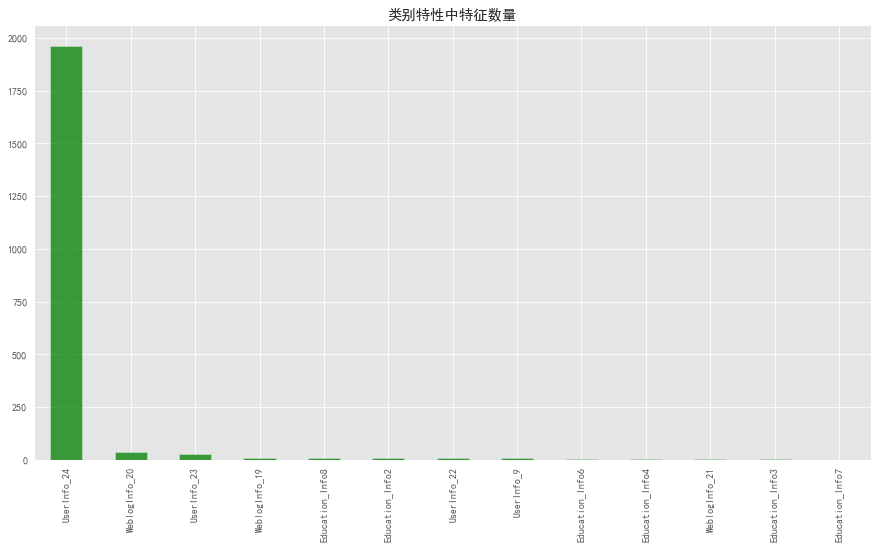

In [98]:
# 创建category_list列表，存储所有类别型特征名称
category_list = ['UserInfo_9']
# 利用feature_list函数创建UserInfo_22-24这3个特征名称，合并入category_list内
category_list.extend(feature_list('UserInfo_', 22, 24))
# 利用feature_list函数创建Education_Info2-4这3个特征名称，合并入category_list内
category_list.extend(feature_list('Education_Info', 2, 4))
# 利用feature_list函数创建Education_Info6-8这3个特征名称，合并入category_list内
category_list.extend(feature_list('Education_Info', 6, 8))
# 利用feature_list函数创建WeblogInfo_19-21这3个特征名称，合并入category_list内
category_list.extend(feature_list('WeblogInfo_', 19, 21))
# 创建category_list列表，存储所有类别型特征名称
category_dic = {}
# b = data['UserInfo_22']

# pdFrame = pd.DataFrame(data= data_nan.values, index= data_nan.index, columns= ['特性缺失值数量'])
for feature in category_list:
#      pd.DataFrame()
    category_dic[feature] = len(data[feature].unique())
sort_list = pd.Series(data=category_dic, index=category_list)
sort_list.sort_values(axis=0,ascending=False,inplace=True)
bar_figure(plot_data=sort_list,title="类别特性中特征数量",figsize=(15,8))

In [99]:
data.columns
list(data.columns)

['Idx',
 'UserInfo_1',
 'UserInfo_2',
 'UserInfo_3',
 'UserInfo_4',
 'WeblogInfo_2',
 'WeblogInfo_4',
 'WeblogInfo_5',
 'WeblogInfo_6',
 'WeblogInfo_7',
 'WeblogInfo_8',
 'WeblogInfo_9',
 'WeblogInfo_10',
 'WeblogInfo_11',
 'WeblogInfo_12',
 'WeblogInfo_13',
 'WeblogInfo_14',
 'WeblogInfo_15',
 'WeblogInfo_16',
 'WeblogInfo_17',
 'WeblogInfo_18',
 'UserInfo_5',
 'UserInfo_6',
 'UserInfo_7',
 'UserInfo_8',
 'UserInfo_9',
 'UserInfo_10',
 'UserInfo_14',
 'UserInfo_15',
 'UserInfo_16',
 'UserInfo_17',
 'UserInfo_18',
 'UserInfo_19',
 'UserInfo_20',
 'UserInfo_21',
 'UserInfo_22',
 'UserInfo_23',
 'UserInfo_24',
 'Education_Info1',
 'Education_Info2',
 'Education_Info3',
 'Education_Info4',
 'Education_Info5',
 'Education_Info6',
 'Education_Info7',
 'Education_Info8',
 'WeblogInfo_19',
 'WeblogInfo_20',
 'WeblogInfo_21',
 'WeblogInfo_23',
 'WeblogInfo_24',
 'WeblogInfo_25',
 'WeblogInfo_26',
 'WeblogInfo_27',
 'WeblogInfo_28',
 'WeblogInfo_29',
 'WeblogInfo_30',
 'WeblogInfo_31',
 'Weblog

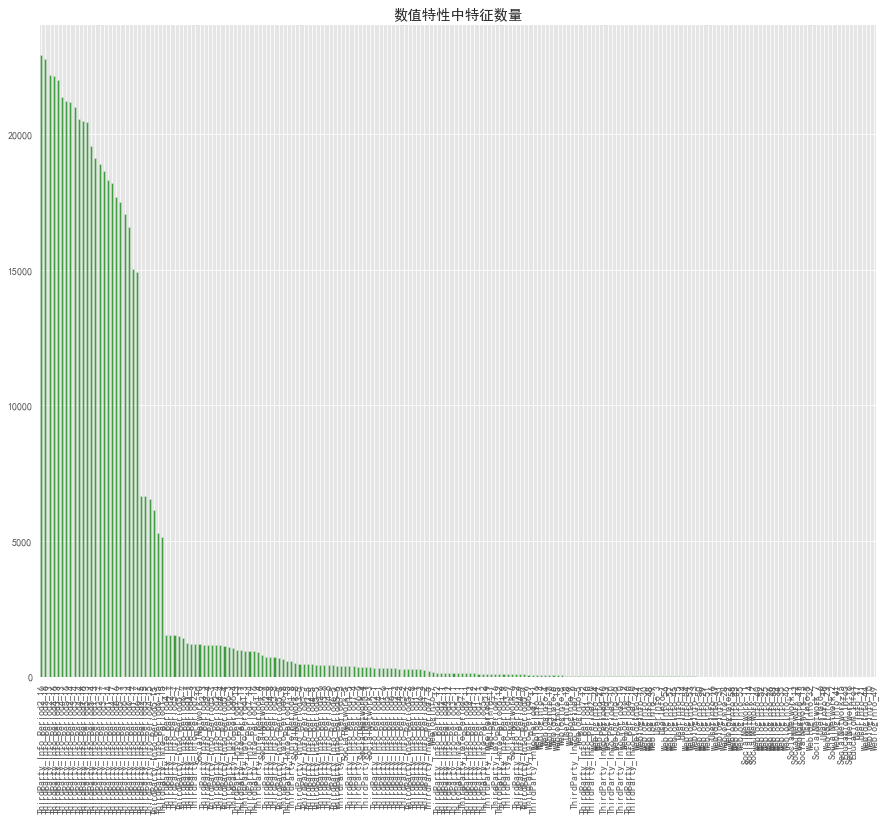

In [100]:
category_list_other = ['Idx', 'UserInfo_2', 'UserInfo_4', 'UserInfo_7', 'UserInfo_8', 
                       'UserInfo_19', 'UserInfo_20', 'target', 'ListingInfo']
# 创建category_list列表，存储所有类别型特征名称
category_list.extend(category_list_other)
all_list = list(data.columns)

for feature in category_list:
    all_list.remove(feature)
    
# 创建category_list列表，存储所有类别型特征名称
number_dic = {}
# b = data['UserInfo_22']

# pdFrame = pd.DataFrame(data= data_nan.values, index= data_nan.index, columns= ['特性缺失值数量'])
for feature in all_list:
#      pd.DataFrame()
    number_dic[feature] = len(data[feature].unique())
sort_list = pd.Series(data=number_dic, index=number_dic)
sort_list.sort_values(axis=0,ascending=False,inplace=True)
bar_figure(plot_data=sort_list,title="数值特性中特征数量",figsize=(15,12))

In [109]:
print("Idx 特征数量为{}".format(len(data['Idx'].unique())))
data = data.set_index('Idx')
data.head()

Idx 特征数量为30000


,UserInfo_1,UserInfo_2,UserInfo_3,UserInfo_4,WeblogInfo_2,WeblogInfo_4,WeblogInfo_5,WeblogInfo_6,WeblogInfo_7,WeblogInfo_8,WeblogInfo_9,WeblogInfo_10,WeblogInfo_11,WeblogInfo_12,WeblogInfo_13,WeblogInfo_14,WeblogInfo_15,WeblogInfo_16,WeblogInfo_17,WeblogInfo_18,UserInfo_5,UserInfo_6,UserInfo_7,UserInfo_8,UserInfo_9,UserInfo_10,UserInfo_14,UserInfo_15,UserInfo_16,UserInfo_17,UserInfo_18,UserInfo_19,UserInfo_20,UserInfo_21,UserInfo_22,UserInfo_23,UserInfo_24,Education_Info1,Education_Info2,Education_Info3,Education_Info4,Education_Info5,Education_Info6,Education_Info7,Education_Info8,WeblogInfo_19,WeblogInfo_20,WeblogInfo_21,WeblogInfo_23,WeblogInfo_24,WeblogInfo_25,WeblogInfo_26,WeblogInfo_27,WeblogInfo_28,WeblogInfo_29,WeblogInfo_30,WeblogInfo_31,WeblogInfo_32,WeblogInfo_33,WeblogInfo_34,WeblogInfo_35,WeblogInfo_36,WeblogInfo_37,WeblogInfo_38,WeblogInfo_39,WeblogInfo_40,WeblogInfo_41,WeblogInfo_42,WeblogInfo_43,WeblogInfo_44,WeblogInfo_45,WeblogInfo_46,WeblogInfo_47,WeblogInfo_48,WeblogInfo_49,WeblogInfo_50,WeblogInfo_51,WeblogInfo_52,WeblogInfo_53,WeblogInfo_54,WeblogInfo_55,WeblogInfo_56,WeblogInfo_57,WeblogInfo_58,ThirdParty_Info_Period1_1,ThirdParty_Info_Period1_2,ThirdParty_Info_Period1_3,ThirdParty_Info_Period1_4,ThirdParty_Info_Period1_5,ThirdParty_Info_Period1_6,ThirdParty_Info_Period1_7,ThirdParty_Info_Period1_8,ThirdParty_Info_Period1_9,ThirdParty_Info_Period1_10,ThirdParty_Info_Period1_11,ThirdParty_Info_Period1_12,ThirdParty_Info_Period1_13,ThirdParty_Info_Period1_14,ThirdParty_Info_Period1_15,ThirdParty_Info_Period1_16,ThirdParty_Info_Period1_17,ThirdParty_Info_Period2_1,ThirdParty_Info_Period2_2,ThirdParty_Info_Period2_3,ThirdParty_Info_Period2_4,ThirdParty_Info_Period2_5,ThirdParty_Info_Period2_6,ThirdParty_Info_Period2_7,ThirdParty_Info_Period2_8,ThirdParty_Info_Period2_9,ThirdParty_Info_Period2_10,ThirdParty_Info_Period2_11,ThirdParty_Info_Period2_12,ThirdParty_Info_Period2_13,ThirdParty_Info_Period2_14,ThirdParty_Info_Period2_15,ThirdParty_Info_Period2_16,ThirdParty_Info_Period2_17,ThirdParty_Info_Period3_1,ThirdParty_Info_Period3_2,ThirdParty_Info_Period3_3,ThirdParty_Info_Period3_4,ThirdParty_Info_Period3_5,ThirdParty_Info_Period3_6,ThirdParty_Info_Period3_7,ThirdParty_Info_Period3_8,ThirdParty_Info_Period3_9,ThirdParty_Info_Period3_10,ThirdParty_Info_Period3_11,ThirdParty_Info_Period3_12,ThirdParty_Info_Period3_13,ThirdParty_Info_Period3_14,ThirdParty_Info_Period3_15,ThirdParty_Info_Period3_16,ThirdParty_Info_Period3_17,ThirdParty_Info_Period4_1,ThirdParty_Info_Period4_2,ThirdParty_Info_Period4_3,ThirdParty_Info_Period4_4,ThirdParty_Info_Period4_5,ThirdParty_Info_Period4_6,ThirdParty_Info_Period4_7,ThirdParty_Info_Period4_8,ThirdParty_Info_Period4_9,ThirdParty_Info_Period4_10,ThirdParty_Info_Period4_11,ThirdParty_Info_Period4_12,ThirdParty_Info_Period4_13,ThirdParty_Info_Period4_14,ThirdParty_Info_Period4_15,ThirdParty_Info_Period4_16,ThirdParty_Info_Period4_17,ThirdParty_Info_Period5_1,ThirdParty_Info_Period5_2,ThirdParty_Info_Period5_3,ThirdParty_Info_Period5_4,ThirdParty_Info_Period5_5,ThirdParty_Info_Period5_6,ThirdParty_Info_Period5_7,ThirdParty_Info_Period5_8,ThirdParty_Info_Period5_9,ThirdParty_Info_Period5_10,ThirdParty_Info_Period5_11,ThirdParty_Info_Period5_12,ThirdParty_Info_Period5_13,ThirdParty_Info_Period5_14,ThirdParty_Info_Period5_15,ThirdParty_Info_Period5_16,ThirdParty_Info_Period5_17,ThirdParty_Info_Period6_1,ThirdParty_Info_Period6_2,ThirdParty_Info_Period6_3,ThirdParty_Info_Period6_4,ThirdParty_Info_Period6_5,ThirdParty_Info_Period6_6,ThirdParty_Info_Period6_7,ThirdParty_Info_Period6_8,ThirdParty_Info_Period6_9,ThirdParty_Info_Period6_10,ThirdParty_Info_Period6_11,ThirdParty_Info_Period6_12,ThirdParty_Info_Period6_13,ThirdParty_Info_Period6_14,ThirdParty_Info_Period6_15,ThirdParty_Info_Period6_16,ThirdParty_Info_Period6_17,ThirdParty_Info_Period7_1,ThirdParty_Info_Period7_2,ThirdParty_Info_Period7_3,ThirdParty_Info_Period7_4,ThirdParty_Info_Period7_5,ThirdParty_Info_Period7_6,ThirdPart

In [110]:
front = data['target']
data.drop('target', axis=1, inplace=True)
data.insert(0,'target',front)
data.head()

,target,UserInfo_1,UserInfo_2,UserInfo_3,UserInfo_4,WeblogInfo_2,WeblogInfo_4,WeblogInfo_5,WeblogInfo_6,WeblogInfo_7,WeblogInfo_8,WeblogInfo_9,WeblogInfo_10,WeblogInfo_11,WeblogInfo_12,WeblogInfo_13,WeblogInfo_14,WeblogInfo_15,WeblogInfo_16,WeblogInfo_17,WeblogInfo_18,UserInfo_5,UserInfo_6,UserInfo_7,UserInfo_8,UserInfo_9,UserInfo_10,UserInfo_14,UserInfo_15,UserInfo_16,UserInfo_17,UserInfo_18,UserInfo_19,UserInfo_20,UserInfo_21,UserInfo_22,UserInfo_23,UserInfo_24,Education_Info1,Education_Info2,Education_Info3,Education_Info4,Education_Info5,Education_Info6,Education_Info7,Education_Info8,WeblogInfo_19,WeblogInfo_20,WeblogInfo_21,WeblogInfo_23,WeblogInfo_24,WeblogInfo_25,WeblogInfo_26,WeblogInfo_27,WeblogInfo_28,WeblogInfo_29,WeblogInfo_30,WeblogInfo_31,WeblogInfo_32,WeblogInfo_33,WeblogInfo_34,WeblogInfo_35,WeblogInfo_36,WeblogInfo_37,WeblogInfo_38,WeblogInfo_39,WeblogInfo_40,WeblogInfo_41,WeblogInfo_42,WeblogInfo_43,WeblogInfo_44,WeblogInfo_45,WeblogInfo_46,WeblogInfo_47,WeblogInfo_48,WeblogInfo_49,WeblogInfo_50,WeblogInfo_51,WeblogInfo_52,WeblogInfo_53,WeblogInfo_54,WeblogInfo_55,WeblogInfo_56,WeblogInfo_57,WeblogInfo_58,ThirdParty_Info_Period1_1,ThirdParty_Info_Period1_2,ThirdParty_Info_Period1_3,ThirdParty_Info_Period1_4,ThirdParty_Info_Period1_5,ThirdParty_Info_Period1_6,ThirdParty_Info_Period1_7,ThirdParty_Info_Period1_8,ThirdParty_Info_Period1_9,ThirdParty_Info_Period1_10,ThirdParty_Info_Period1_11,ThirdParty_Info_Period1_12,ThirdParty_Info_Period1_13,ThirdParty_Info_Period1_14,ThirdParty_Info_Period1_15,ThirdParty_Info_Period1_16,ThirdParty_Info_Period1_17,ThirdParty_Info_Period2_1,ThirdParty_Info_Period2_2,ThirdParty_Info_Period2_3,ThirdParty_Info_Period2_4,ThirdParty_Info_Period2_5,ThirdParty_Info_Period2_6,ThirdParty_Info_Period2_7,ThirdParty_Info_Period2_8,ThirdParty_Info_Period2_9,ThirdParty_Info_Period2_10,ThirdParty_Info_Period2_11,ThirdParty_Info_Period2_12,ThirdParty_Info_Period2_13,ThirdParty_Info_Period2_14,ThirdParty_Info_Period2_15,ThirdParty_Info_Period2_16,ThirdParty_Info_Period2_17,ThirdParty_Info_Period3_1,ThirdParty_Info_Period3_2,ThirdParty_Info_Period3_3,ThirdParty_Info_Period3_4,ThirdParty_Info_Period3_5,ThirdParty_Info_Period3_6,ThirdParty_Info_Period3_7,ThirdParty_Info_Period3_8,ThirdParty_Info_Period3_9,ThirdParty_Info_Period3_10,ThirdParty_Info_Period3_11,ThirdParty_Info_Period3_12,ThirdParty_Info_Period3_13,ThirdParty_Info_Period3_14,ThirdParty_Info_Period3_15,ThirdParty_Info_Period3_16,ThirdParty_Info_Period3_17,ThirdParty_Info_Period4_1,ThirdParty_Info_Period4_2,ThirdParty_Info_Period4_3,ThirdParty_Info_Period4_4,ThirdParty_Info_Period4_5,ThirdParty_Info_Period4_6,ThirdParty_Info_Period4_7,ThirdParty_Info_Period4_8,ThirdParty_Info_Period4_9,ThirdParty_Info_Period4_10,ThirdParty_Info_Period4_11,ThirdParty_Info_Period4_12,ThirdParty_Info_Period4_13,ThirdParty_Info_Period4_14,ThirdParty_Info_Period4_15,ThirdParty_Info_Period4_16,ThirdParty_Info_Period4_17,ThirdParty_Info_Period5_1,ThirdParty_Info_Period5_2,ThirdParty_Info_Period5_3,ThirdParty_Info_Period5_4,ThirdParty_Info_Period5_5,ThirdParty_Info_Period5_6,ThirdParty_Info_Period5_7,ThirdParty_Info_Period5_8,ThirdParty_Info_Period5_9,ThirdParty_Info_Period5_10,ThirdParty_Info_Period5_11,ThirdParty_Info_Period5_12,ThirdParty_Info_Period5_13,ThirdParty_Info_Period5_14,ThirdParty_Info_Period5_15,ThirdParty_Info_Period5_16,ThirdParty_Info_Period5_17,ThirdParty_Info_Period6_1,ThirdParty_Info_Period6_2,ThirdParty_Info_Period6_3,ThirdParty_Info_Period6_4,ThirdParty_Info_Period6_5,ThirdParty_Info_Period6_6,ThirdParty_Info_Period6_7,ThirdParty_Info_Period6_8,ThirdParty_Info_Period6_9,ThirdParty_Info_Period6_10,ThirdParty_Info_Period6_11,ThirdParty_Info_Period6_12,ThirdParty_Info_Period6_13,ThirdParty_Info_Period6_14,ThirdParty_Info_Period6_15,ThirdParty_Info_Period6_16,ThirdParty_Info_Period6_17,ThirdParty_Info_Period7_1,ThirdParty_Info_Period7_2,ThirdParty_Info_Period7_3,ThirdParty_Info_Period7_4,ThirdParty_Info_Period7_5,ThirdParty_Info_Period7_6,Th

In [113]:
'''
3、UserInfo数据处理:

3.1、查看UserInfo数据总体情况
在第一轮预处理中，由于UserInfo_11、UserInfo_12、UserInfo_13这三个特征缺失值过多，已经做删除处理
目前UserInfo特征共有UserInfo_1-10和UserInfo_14-24，共21个特征
首先，通过feature_list函数将所有的UserInfo特征合并到一个列表userinfo_feature_list内
其次，利用describe方法查看所有UserInfo特征的总体信息
'''
# 创建空列表，用来存储所有UserInfo特征名
userinfo_feature_list = []
# 利用feature_list生成UserInfo_1-UserInfo_10这10个特征名称，并合并入userinfo_feature_list内
userinfo_feature_list.extend(feature_list('UserInfo_', 1, 10))
# 利用feature_list生成UserInfo_14-UserInfo_24这11个特征名称，并合并入userinfo_feature_list内
userinfo_feature_list.extend(feature_list('UserInfo_', 14, 24))
# 通过pandas的describe方法，查看每个特征的信息
data[userinfo_feature_list].describe(include= 'all')

,UserInfo_1,UserInfo_2,UserInfo_3,UserInfo_4,UserInfo_5,UserInfo_6,UserInfo_7,UserInfo_8,UserInfo_9,UserInfo_10,UserInfo_14,UserInfo_15,UserInfo_16,UserInfo_17,UserInfo_18,UserInfo_19,UserInfo_20,UserInfo_21,UserInfo_22,UserInfo_23,UserInfo_24
count,30000.000,30000,30000.000,30000,30000.000,30000.000,30000,30000,30000,30000.000,30000.000,30000.000,30000.000,30000.000,30000.000,30000,30000,30000.000,30000,30000,30000
unique,nan,327,nan,330,nan,nan,32,655,7,nan,nan,nan,nan,nan,nan,31,297,nan,7,27,1963
top,nan,深圳,nan,深圳,nan,nan,不详,不详,中国移动,nan,nan,nan,nan,nan,nan,广东省,不详,nan,D,D,D
freq,nan,1048,nan,1112,nan,nan,4213,4213,15481,nan,nan,nan,nan,nan,nan,2405,7173,nan,27867,27867,27867
mean,3.219,NaN,4.694,NaN,1.654,1.654,NaN,NaN,NaN,0.311,3.417,3.421,1.612,1.129,29.782,NaN,NaN,0.071,NaN,NaN,NaN
std,1.828,NaN,1.321,NaN,0.585,0.584,NaN,NaN,NaN,0.604,1.171,1.168,1.060,0.336,6.421,NaN,NaN,0.257,NaN,NaN,NaN
min,0.000,NaN,0.000,NaN,1.000,1.000,NaN,NaN,NaN,0.000,0.000,0.000,0.000,1.000,0.000,NaN,NaN,0.000,NaN,NaN,NaN
25%,1.000,NaN,4.000,NaN,1.000,1.000,NaN,NaN,NaN,0.000,3.000,3.000,1.000,1.000,25.000,NaN,NaN,0.000,NaN,NaN,NaN
50%,3.000,NaN,5.000,NaN,2.000,2.000,NaN,NaN,NaN,0.000,3.000,3.000,1.000,1.000,28.000,NaN,NaN,0.000,NaN,NaN,NaN
75%,5.000,NaN,5.000,NaN,2.000,2.000,NaN,NaN,NaN,0.000,4.000,4.000,2.000,1.000,33.000,NaN,NaN,0.000,NaN,NaN,NaN


In [ ]:
'''
3.2、UserInfo特征分类:
通过3.1查看每个UserInfo特征信息，可知：
UserInfo_2、UserInfo_4、UserInfo_7-9、UserInfo_19-20、UserInfo_22-24为类别型特征
UserInfo_1、UserInfo_3、UserInfo_5-6、UserInfo_10、UserInfo_14-18、UserInfo_21为数值型特征
'''
# 1、将所有类别型特征名称存入userinfo_category_list
# 创建userinfo_category_list列表，用来存储UserInfo的类别型特征
userinfo_category_list = ['UserInfo_2', 'UserInfo_4']
# 利用feature_list函数生成UserInfo_7-UserInfo_9这3个特征名称，并将结果合并入存入userinfo_category_list
userinfo_category_list.extend(feature_list('UserInfo_', 7, 9))
# 利用feature_list函数生成UserInfo_19-UserInfo_20这2个特征名称，并将结果合并入存入userinfo_category_list
userinfo_category_list.extend(feature_list('UserInfo_', 19, 20))
# 利用feature_list函数生成UserInfo_22-UserInfo_24这3个特征名称，并将结果合并入存入userinfo_category_list
userinfo_category_list.extend(feature_list('UserInfo_', 22, 24))

# 2、将所有数值型特征名称存入userinfo_numerical_list
# 创建userinfo_numerical_list列表，用来存储UserInfo的数值型特征
userinfo_numerical_list = ['UserInfo_1', 'UserInfo_3', 'UserInfo_10', 'UserInfo_21']
# 利用feature_list函数生成UserInfo_5-UserInfo_6这2个特征名称，并将结果合并入存入userinfo_numerical_list
userinfo_numerical_list.extend(feature_list('UserInfo_', 5, 6))
# 利用feature_list函数生成UserInfo_14-UserInfo_18这5个特征名称，并将结果合并入存入userinfo_numerical_list
userinfo_numerical_list.extend(feature_list('UserInfo_', 14, 18))


> #### 2. 特征选择
200多个特征里可能有效的特征不会很多。在这里做特征选择相关的工作。 在特征选择这一块请使用```树```模型。 比如sklearn自带的特征选择模块（https://scikit-learn.org/stable/modules/feature_selection.html）， 或者直接使用XGBoost等模型来直接选择。 这些模型训练好之后你可以直接通过```feature_importance_values```属性来获取。

> #### 3. XGBoost来训练风控模型，结果以AUC为准
https://github.com/dmlc/xgboost   这是XGBoost library具体的地址, 具有详细的文档。 https://pypi.org/project/xgboost/ 里有安装的步骤。 试着去调一下它的超参数，使得得到最好的效果。 一定要注意不需要使用测试数据来训练。 最终的结果以测试数据上的AUC为标准。 

In [2]:
data_test = pd.read_csv('data/Test/PPD_Master_GBK_2_Test_Set.csv',encoding='gb18030')
